In [1]:
!unzip /content/drive/MyDrive/samples.zip

Streaming output truncated to the last 5000 lines.
  inflating: samples/X/1002.png      
  inflating: samples/X/1003.png      
  inflating: samples/X/1004.png      
  inflating: samples/X/1005.png      
  inflating: samples/X/1006.png      
  inflating: samples/X/1007.png      
  inflating: samples/X/1008.png      
  inflating: samples/X/1009.png      
  inflating: samples/X/1010.png      
  inflating: samples/X/1011.png      
  inflating: samples/X/1012.png      
  inflating: samples/X/1013.png      
  inflating: samples/X/1014.png      
  inflating: samples/X/1015.png      
  inflating: samples/X/1016.png      
  inflating: samples/X/1017.png      
  inflating: samples/X/1018.png      
  inflating: samples/X/1019.png      
  inflating: samples/X/1020.png      
  inflating: samples/X/1021.png      
  inflating: samples/X/1022.png      
  inflating: samples/X/1023.png      
  inflating: samples/X/1024.png      
  inflating: samples/X/1025.png      
  inflating: samples/X/1026.png      

In [10]:
batch_size = 16
image_size = 64  # Change to 64
num_classes = 29  # 29 classes for A-Z, del, space, nothing
epochs = 50
train_len = 58000  # Adjust based on your dataset

In [11]:
train_dir = '/content/samples'

In [5]:
import numpy as np
import os
import cv2
import skimage.transform
import tensorflow as tf

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
X = np.empty((train_len, image_size, image_size, 3), dtype=np.float32)
y = np.empty((train_len,), dtype=np.int64)

In [13]:
# Load data
X = np.empty((train_len, image_size, image_size, 3), dtype=np.float32)
y = np.empty((train_len,), dtype=np.int64)
cnt = 0
label_mapping = {chr(i + 65): i for i in range(26)}  # A-Z
label_mapping.update({'del': 26, 'nothing': 27, 'space': 28})



In [14]:
for folderName in os.listdir(train_dir):
    if not folderName.startswith('.'):
        label = label_mapping.get(folderName, 29)
        for image_filename in os.listdir(os.path.join(train_dir, folderName)):
            img_file = cv2.imread(os.path.join(train_dir, folderName, image_filename))
            if img_file is not None:
                img_file = skimage.transform.resize(img_file, (image_size, image_size, 3))
                X[cnt] = img_file
                y[cnt] = label
                cnt += 1

In [15]:
train_len = cnt

# Resize the arrays to the actual loaded size
X = X[:cnt]
y = y[:cnt]

print('Done loading data')
print(f"Loaded {cnt} images")


Done loading data
Loaded 58000 images


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
y_cat_train = to_categorical(y_train, num_classes)
y_cat_test = to_categorical(y_test, num_classes)

In [17]:
print(f"X_train shape: {X_train.shape}, y_cat_train shape: {y_cat_train.shape}")
print(f"X_test shape: {X_test.shape}, y_cat_test shape: {y_cat_test.shape}")

X_train shape: (40600, 64, 64, 3), y_cat_train shape: (40600, 29)
X_test shape: (17400, 64, 64, 3), y_cat_test shape: (17400, 29)


In [18]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)

In [19]:
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
early_stop = EarlyStopping(monitor='val_loss', patience=4)
checkpoint_filepath = 'checkpoints/best_model.weights.h5'  # Corrected filepath
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)


In [24]:
history = model.fit(X_train, y_cat_train, epochs=epochs, batch_size=batch_size, verbose=2,
                    validation_data=(X_test, y_cat_test), callbacks=[early_stop, model_checkpoint_callback])

Epoch 1/50
2538/2538 - 65s - 26ms/step - accuracy: 0.4408 - loss: 1.9887 - val_accuracy: 0.6618 - val_loss: 1.2133
Epoch 2/50
2538/2538 - 58s - 23ms/step - accuracy: 0.7178 - loss: 0.9673 - val_accuracy: 0.7707 - val_loss: 0.7861
Epoch 3/50
2538/2538 - 41s - 16ms/step - accuracy: 0.8042 - loss: 0.6650 - val_accuracy: 0.8167 - val_loss: 0.5855
Epoch 4/50
2538/2538 - 36s - 14ms/step - accuracy: 0.8504 - loss: 0.5070 - val_accuracy: 0.8559 - val_loss: 0.4777
Epoch 5/50
2538/2538 - 35s - 14ms/step - accuracy: 0.8771 - loss: 0.4116 - val_accuracy: 0.8979 - val_loss: 0.3566
Epoch 6/50
2538/2538 - 35s - 14ms/step - accuracy: 0.8939 - loss: 0.3504 - val_accuracy: 0.9129 - val_loss: 0.2924
Epoch 7/50
2538/2538 - 40s - 16ms/step - accuracy: 0.9056 - loss: 0.3065 - val_accuracy: 0.8963 - val_loss: 0.3223
Epoch 8/50
2538/2538 - 35s - 14ms/step - accuracy: 0.9165 - loss: 0.2703 - val_accuracy: 0.9270 - val_loss: 0.2308
Epoch 9/50
2538/2538 - 41s - 16ms/step - accuracy: 0.9247 - loss: 0.2445 - val_a

In [25]:
metrics = pd.DataFrame(history.history)

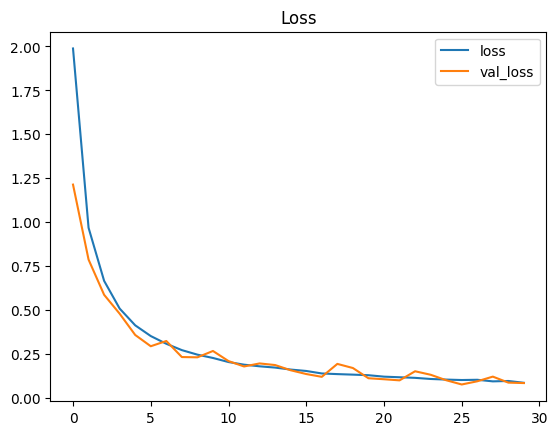

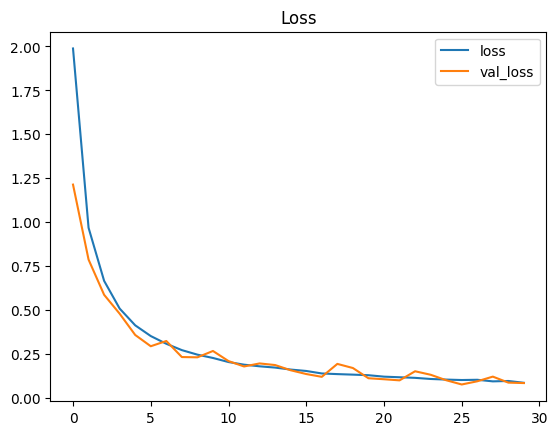

In [26]:
metrics[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.show()

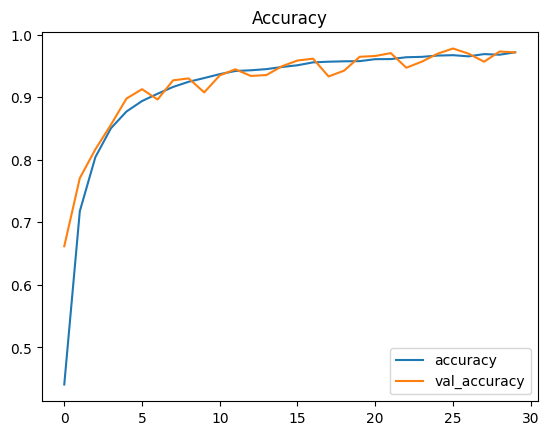

In [28]:
metrics[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.show()

In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_cat_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 97.17%


In [30]:
predictions = model.predict(X_test)
predictions_classes = np.argmax(predictions, axis=1)
print(classification_report(y_test, predictions_classes))

544/544 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       600
           1       0.99      0.99      0.99       600
           2       0.99      1.00      1.00       600
           3       0.99      0.97      0.98       600
           4       0.96      0.97      0.96       600
           5       1.00      0.96      0.98       600
           6       0.99      0.99      0.99       600
           7       0.97      1.00      0.98       600
           8       0.94      0.99      0.96       600
           9       0.99      1.00      1.00       600
          10       1.00      0.92      0.96       600
          11       0.99      0.99      0.99       600
          12       0.99      1.00      0.99       600
          13       0.98      0.99      0.99       600
          14       0.95      0.99      0.97       600
          15       1.00      0.99      1.00       600
          16       1.00      0.98     

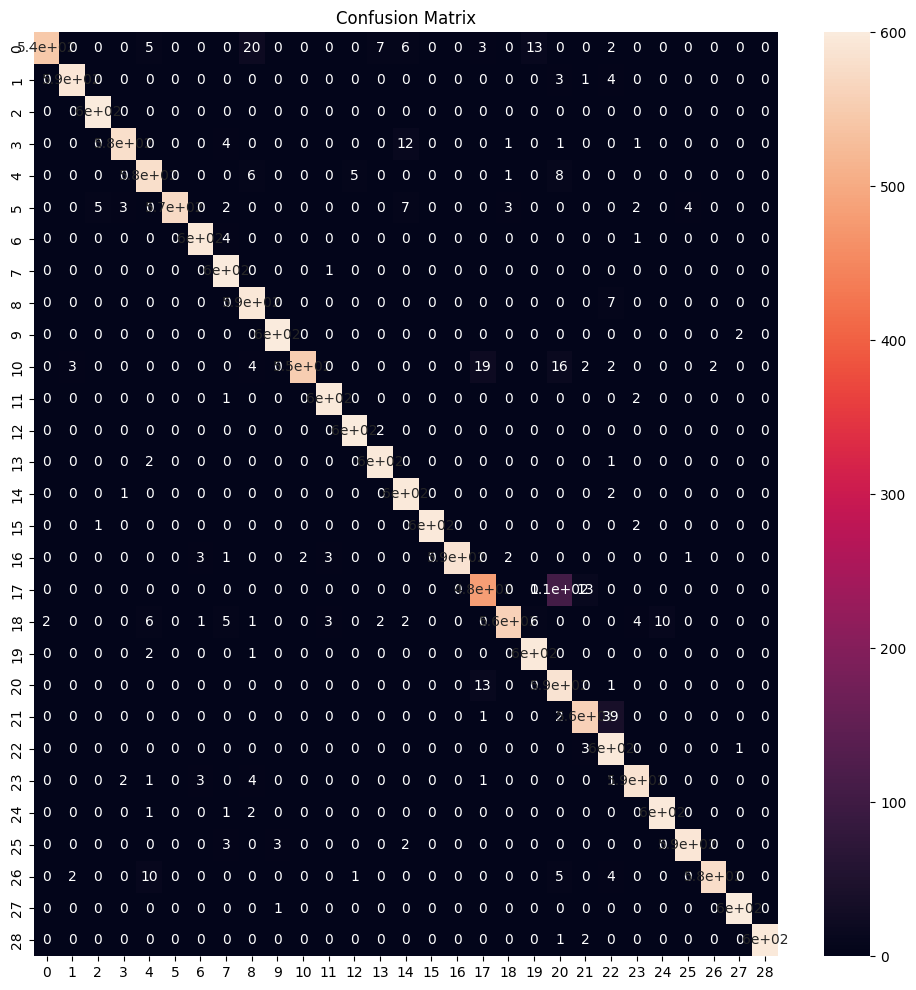

In [31]:
plt.figure(figsize=(12, 12))
sns.heatmap(confusion_matrix(y_test, predictions_classes), annot=True)
plt.title('Confusion Matrix')
plt.show()

In [32]:
# Save the model
model.save('Resnet.h5')  # Replace with your desired path


In [33]:
print(predictions_classes)  # Predicted classes
print(y_test)

[19  0  8 ... 16 13  0]
[19  0  8 ... 16 13  0]
